In [1]:
# https://zhuanlan.zhihu.com/p/690355021
import math
import logging
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)
formatter = logging.Formatter(
    "==="
    "[%(asctime)s - %(levelname)s - %(name)s - %(funcName)s:%(lineno)d]"
    "===\n"
    "%(message)s\n"
)
# 对logger设置输出格式
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim=256, num_heads=4):
        """
        hidden_dim: 输入的维度
        num_heads: 输入分成的注意头数量

        learning parameter matrices由Linear的layer维护，并且将多个heads放入
        一个weight tensor， 使得我们可以方便地更新梯度。
        各个head的对应Q,K,V矩阵不一定为方阵，shape为(d_k,d).
        d_k=hidden_dim/num_dim，d=hidden_dim。需要注意在Wa中，Q矩阵是如何分布的?
        先说答案，在Wq.weight中，每d_k行组成的矩阵为每个head的learning parameter mat.
        Wk和Wv也有类似的结论。

        我们记每个head的Q和K的矩阵形状为(d_k,d),那么第i个head的Q中，
        应该是Wq.weight[(i*d_k):((i+1)*d_k),d]。
        注意，nn.Linear.weight的shape为(out_features, in_features)，所以其forward
        操作为X @ weight.T。得到结果中，每d_k列为一个head的映射结果。
        对应到学习参数矩阵，weight[]中第一维(行)用d_k索引，第二维(列)用d索引。
        即weight.T = multi_head_q，而mulit_head_q的shape为(d_k * num_heads, d)

        最开始传入q给Wq处理 (传入参数很大可能是q=k=v)。q的size为
        (batch_size, length, hidden_num),length即x向量的数量。
        执行映射过程为q = self.Wq(q)
        即是计算从输入映射后得到的结果，进一步用于计算attention weight。
        最后一维作为单个输入的向量，记为x，交由Wq执行映射。对于每个输入向量x，我们需要
        得到num_heads个向量。 最后得到的结果是(batch_size, length, num_heads * d_k)
        最后一维是按照head堆叠起来的，每个有hidden_num个分量的向量，就是一个
        num_heads个d_k维的向量。也就是将结果转换成了d_w维度。
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        assert (
            hidden_dim % num_heads == 0
        ), "hidden_dim must be the integer times of num_heads"
        self.Wq = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.Wk = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.Wv = nn.Linear(hidden_dim, hidden_dim, bias=False)
        # multi-head attention最后一步，在num_heads的结果输出后，将这些向量concat，
        # 并输入此fc
        self.Wo = nn.Linear(hidden_dim, hidden_dim, bias=False)

    def _check_scaled_dot_product_attention_inputs(self, x):
        """
        check scaled dot-product attention inputs

        要求x是 (B, H, len, d_k)的
        """
        assert x.size(1) == self.num_heads, (
            f"expects that x has shape as:"
            f" ({-1, self.num_heads, -1, self.hidden_dim // self.num_heads}),"
            f"but get {x.size()}"
        )
        # assert d_k is ok.
        assert x.size(3) == self.hidden_dim // self.num_heads

    def _scaled_dot_product_attention(
        self, query, key, value, attention_mask=None, key_padding_mask=None
    ):
        """
        query: tensor, shape is
        (batch_size, num_heads, query_sequence_length, hidden_dim//num_heads)
        key: tensor, shape is
        (batch_size, num_heads, key_sequence_length, hidden_dim // num_heads)
        value: tensor, shape is
        (batch_size, num_heads, value_sequence_length, hidden_dim//num_heads)
        attention_mask: tensor, shape is
        (query_sequence_length, key_sequence_length)
        key_padding_mask: tensor, shape is
        (sequence_length, key_sequence_length)

        query最开始是(batch_size, query_sequence_length, hidden_dim)的,w，
        经过split_into_heads后的结果。
        """
        self._check_scaled_dot_product_attention_inputs(query)
        self._check_scaled_dot_product_attention_inputs(key)
        self._check_scaled_dot_product_attention_inputs(value)

        d_k = key.size(-1)
        # tgt_len and src_len is sequence_length，也就是当前batch中字母的个数
        tgt_len, src_len = query.size(-2), key.size(-2)

        # logits = (B, H, tgt_len, E) * (B, H, E, src_len) =
        # (B, H, tgt_len, src_len)
        logits = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

        # 注意力遮罩
        if attention_mask is not None:
            if attention_mask.dim() == 2:
                # 保证能够正常作用于q和k
                assert attention_mask.size() == (tgt_len, src_len)
                # reshape为 (1, query_sequence_length, key_sequence_length)
                # 方便于logits广播
                # attention_mask = attention_mask.unsqueeze(0)
                logger.info(
                    f"attention mask size is {attention_mask.size()}\n"
                    f"logits size is {logits.size()}"
                )
                logits = logits + attention_mask
            else:
                raise ValueError(
                    f"attention_mask.size() is invalid: {attention_mask.size()}"
                )

        if key_padding_mask is not None:
            if key_padding_mask.dim() == 2:
                assert key_padding_mask.size() == (
                    query.size(0),
                    key.size(2),
                ), (
                    f"key_padding_mask.size() is invalid:"
                    f"{key_padding_mask.size()}\nbatch size is {query.size(0)}, "
                    f"sequence size is {key.size(2)}"
                )
                """
                在批次大小，注意力头上广播。有logits的维度是
                (batch_size, num_heads, query_sequence_length, key_sequence_length)
                key_padding_mask的维度是(batch_size, key_sequence_length)
                广播后，key_padding_mask的维度是
                (batch_size, num_heads, query_sequence_length, key_sequence_length)
                这样，broadcast机制就可以直接作用到logits的最后两个维度上。
                """
                key_padding_mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
                # 直接使用广播机制与logits的最后两个维度相加
                logger.info(
                    f"key_padding_mask.size() is:{key_padding_mask.size()}\n"
                    f"logits.size() is:{logits.size()}"
                )
                logits = logits + key_padding_mask
            else:
                raise ValueError(
                    f"key_padding_mask.size() is invalid: {key_padding_mask.size()}"
                )

        attention = torch.softmax(logits, dim=-1)
        # (batch_size, num_heads, sequence_length, hidden_dim)
        output = torch.matmul(attention, value)
        return output, attention

    def _split_into_heads(self, x):
        batch_size, seq_length, hidden_dim = x.size()
        d_k = hidden_dim // self.num_heads
        # 拆解了最后一维，方便送到每个head的learning parameter matrices
        x = x.view(batch_size, seq_length, self.num_heads, d_k)
        # 最终返回(batch_size, num_heads, seq_length, hidden_dim // num_heads)
        return x.transpose(1, 2)

    # 上一个方法的逆操作
    def _combine_heads(self, x):
        batch_size, num_heads, seq_length, head_hidden_dim = x.size()
        return (
            x.transpose(1, 2)
            .contiguous()
            .view(batch_size, seq_length, num_heads * head_hidden_dim)
        )

    def forward(self, q, k, v, attention_mask=None, key_padding_mask=None):
        """
        q: tensor, shape is (batch_size, query_sequence_length, hidden_dim)
        k: tensor, shape is (batch_size, key_sequence_length, hidden_dim)
        v: tensor, shape is (batch_size, value_sequence_length, hidden_dim)
        attention_mask: tensor, shape is
        (query_sequence_length, key_sequence_length)
        key_padding_mask: tensor, shape is (sequence_length, key_sequence_length)
        """
        q = self.Wq(q)
        k = self.Wk(k)
        v = self.Wv(v)

        q = self._split_into_heads(q)
        k = self._split_into_heads(k)
        v = self._split_into_heads(v)

        attention_values, attention_weights = (
            self._scaled_dot_product_attention(
                q, k, v, attention_mask, key_padding_mask
            )
        )
        grouped = self._combine_heads(attention_values)
        output = self.Wo(grouped)

        self.attention_weights = attention_weights
        return output


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = dropout

        pe = torch.zeros(max_len, d_model)
        # shape: (max_len, 1)
        positions = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        # e^((2k/d_model) * -ln(10000)) = (e^(-ln(10000)))^(2k/d_model)
        # = (1/10000)^(2k/d_model)
        # 省略了求幂的操作，求对数更高效
        division_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10_000) / d_model)
        )
        pe[:, 0::2] = torch.sin(positions / division_term)
        pe[:, 1::2] = torch.cos(positions / division_term)
        # 因为操作都会用batch，所以unsqueeze
        # shape: (1, max_len, d_model)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: Tensor, shape is [batch_size, sequence_length, embedding_dim]
        """
        # 通过广播，每个batch，都会在pe[0, :x.size(1), :]处加上对应的结果。
        x = x + self.pe[:, : x.size(1), :]
        return x


class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class EncoderBlock(nn.Module):
    def __init__(self, n_dim: int, dropout: float, n_heads: int) -> None:
        super().__init__()
        self.mha = MultiHeadAttention(hidden_dim=n_dim, num_heads=n_heads)
        self.norm1 = nn.LayerNorm(n_dim)
        self.dropout = nn.Dropout(dropout)
        self.feed_forward = PositionWiseFeedForward(n_dim, n_dim)
        self.norm2 = nn.LayerNorm(n_dim)

    def forward(self, x, src_padding_mask=None):
        assert x.ndim == 3, f"Expected input to be 3-dim, got {x.ndim}"
        attention_output = self.mha(x, x, x, key_padding_mask=src_padding_mask)
        attention_output = self.norm1(attention_output)
        # Resudual connection
        x = x + self.dropout(attention_output)

        x = self.feed_forward(x)
        # Resudual connection
        x = x + self.norm2(x)
        return x


class Encoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        n_dim: int,
        dropout: float,
        n_encoder_blocks: int,
        n_heads: int,
    ) -> None:
        super().__init__()
        self.n_dim = n_dim
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=n_dim
        )
        self.positional_encoding = PositionalEncoding(n_dim, dropout=dropout)
        self.encoder_blocks = nn.ModuleList(
            [
                EncoderBlock(n_dim, dropout, n_heads)
                for _ in range(n_encoder_blocks)
            ]
        )

    def forward(self, x, padding_mask=None):
        # Transformer论文中，指出需要对embedding vector乘以sqrt(d_model)
        x = self.embedding(x) * math.sqrt(self.n_dim)
        x = self.positional_encoding(x)
        for block in self.encoder_blocks:
            x = block(x, padding_mask)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, n_dim: int, dropout: float, n_heads: int) -> None:
        super().__init__()
        # The first multi-head attention is to be masked to prevent seeing the future infomations.
        self.self_attention = MultiHeadAttention(
            hidden_dim=n_dim, num_heads=n_heads
        )
        self.norm1 = nn.LayerNorm(n_dim)
        # The second multi-head attention takes the outputs from encoder
        self.cross_attention = MultiHeadAttention(
            hidden_dim=n_dim, num_heads=n_heads
        )
        self.norm2 = nn.LayerNorm(n_dim)

        self.feed_forward = PositionWiseFeedForward(n_dim, n_dim)
        self.norm3 = nn.LayerNorm(n_dim)

    def forward(
        self,
        tgt,
        memory,
        tgt_mask=None,
        tgt_padding_mask=None,
        memory_padding_mask=None,
    ):
        """
        memory: come from encoder
        """
        masked_attention_output = self.self_attention(
            q=tgt,
            k=tgt,
            v=tgt,
            attention_mask=tgt_mask,
            key_padding_mask=tgt_padding_mask,
        )
        # resudual connection
        x1 = tgt + self.norm1(masked_attention_output)

        cross_attention_output = self.cross_attention(
            q=x1,
            k=memory,
            v=memory,
            attention_mask=None,
            key_padding_mask=memory_padding_mask,
        )
        # resudual connection
        x2 = x1 + self.norm2(cross_attention_output)
        ff_output = self.feed_forward(x2)
        # resudual connection
        output = x2 + self.norm3(ff_output)
        return output


class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        n_dim: int,
        dropout: float,
        n_decoder_blocks: int,
        n_heads: int,
    ) -> None:
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=n_dim
        )
        self.positional_encoding = PositionalEncoding(
            d_model=n_dim, dropout=dropout
        )
        self.decoder_blocks = nn.ModuleList(
            [
                DecoderBlock(n_dim=n_dim, dropout=dropout, n_heads=n_heads)
                for _ in range(n_decoder_blocks)
            ]
        )

    def forward(
        self,
        tgt,
        memory,
        tgt_mask=None,
        tgt_padding_mask=None,
        memory_padding_mask=None,
    ):
        x = self.embedding(tgt)
        x = self.positional_encoding(x)
        for block in self.decoder_blocks:
            x = block(
                tgt=x,
                memory=memory,
                tgt_mask=tgt_mask,
                tgt_padding_mask=tgt_padding_mask,
                memory_padding_mask=memory_padding_mask,
            )
        return x


class Transformer(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()

        for k, v in kwargs.items():
            print(f" * {k}={v}")

        self.vocab_size = kwargs.get("vocab_size")
        self.model_dim = kwargs.get("model_dim")
        self.dropout = kwargs.get("dropout")
        self.n_encoder_layers = kwargs.get("n_encoder_layers")
        self.n_decoder_layers = kwargs.get("n_decoder_layers")
        self.n_heads = kwargs.get("n_heads")
        self.batch_size = kwargs.get("batch_size")
        self.PAD_IDX = kwargs.get("pad_idx", 0)

        self.encoder = Encoder(
            self.vocab_size,
            self.model_dim,
            self.dropout,
            self.n_encoder_layers,
            self.n_heads,
        )
        self.decoder = Decoder(
            self.vocab_size,
            self.model_dim,
            self.dropout,
            self.n_decoder_layers,
            self.n_heads,
        )
        # 最后输出(B,S,vocab_size)，由于没有激活层，所以是logits
        self.fc = nn.Linear(self.model_dim, self.vocab_size)

    @staticmethod
    def generate_square_subsequent_mask(size: int):
        """
        生成一个大小为 (size, size) 的上三角形状的掩码。来自 PyTorch 文档。

        return:
            主对角线及下三角为0.0，其余为-inf
        """
        mask = (1 - torch.triu(torch.ones(size, size), diagonal=1)).bool()
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, 0.0)
        )
        return mask

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """
        input:
            x: (B, S), B是batch size, S是序列长度，比如单词padding之后的长度。
            在Embedded层处理后，S会被处理，每个字符会被Embedded层映射到常委model_dim
            的rank-1 tensor，最后映射得到(B, S, model_dim)
        output:
            (B, S, model_dim)
        """
        # 在encoder中，mask掉pad_idx对应的位置
        mask = (x == self.PAD_IDX).float()
        # 将x的填充部分设置为-inf
        # encoder_padding_mask与x有相同size，shape为(B, S)
        # 此时还没有经过Embeded层处理。比如：
        encoder_padding_mask = mask.masked_fill(mask == 1, float("-inf"))
        logger.info(
            f"encoder start, encoder padding mask size is {encoder_padding_mask.size()}"
        )
        # (B, S, E)
        # 此mask作为MHA的scaled dot product attention中的key_padding_mask参数。
        encoder_output = self.encoder(x, padding_mask=encoder_padding_mask)
        logger.info(
            f"encoder output has size {encoder_output.size()}\n"
            f"memory mask size is {encoder_padding_mask.size()}"
        )
        return encoder_output, encoder_padding_mask

    def decode(
        self, tgt: torch.Tensor, memory: torch.Tensor, memory_padding_mask=None
    ) -> torch.Tensor:
        """
        B for Batch size, S for source sequence length, L for target sequence
        length, E for embedding dimension.

        intput:
            encoded_x: (B, S, E)
            y: (B, L), 元素在(0, C)区间内
        output:
            (B, L, C)
        """

        mask = (tgt == self.PAD_IDX).float()
        tgt_padding_mask = mask.masked_fill(mask == 1, float("-inf"))
        logger.info(
            f"decoder start, tgt padding mask size is {tgt_padding_mask.size()}"
        )

        decoder_output = self.decoder(
            tgt=tgt,
            memory=memory,
            tgt_mask=self.generate_square_subsequent_mask(tgt.size(1)),
            tgt_padding_mask=tgt_padding_mask,
            memory_padding_mask=memory_padding_mask,
        )
        logger.info(
            f"decoder output (before fc) has size {decoder_output.size()}"
        )
        output = self.fc(decoder_output)
        return output

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        input:
            x: (B, Sx), Sx是单词的padding之后的长度。
            y: (B, Sy), Sy是单词的padding之后的长度。
        output:
            (B, L, C)
        """

        # Encoder output a tensor with shape (B, S, E)
        encoder_output, encoder_padding_mask = self.encode(x)
        # Decoder output a tensor with shape (B, L, C)
        decoder_output = self.decode(
            tgt=y,
            memory=encoder_output,
            memory_padding_mask=encoder_padding_mask,
        )
        return decoder_output

    def predict(
        self,
        x: torch.Tensor,
        start_of_sentence_index: int = 1,
        end_of_sentence_index: int = 2,
        max_length: int = None,
    ) -> torch.Tensor:
        """
        推断时候使用此方法。逐个标记。
        input:
            x: a single str Tensor
        output:
            (B, L, C), the last is logits
        """
        # 标记句子开头与结尾
        x = torch.cat(
            [
                torch.tensor([start_of_sentence_index]),
                x,
                torch.tensor([end_of_sentence_index]),
            ]
        ).unsqueeze(0)
        encoder_output, mask = self.transformer.encoder(x)  # (B, S, E)

        if not max_length:
            # 默认使用句子长度作为最大长度
            # 这也是我们样例中，反转句子的要求，与输入同长。
            max_length = x.size(1)

        outputs = (
            torch.ones((x.size()[0], max_length)).type_as(x).long()
            * start_of_sentence_index
        )
        for step in range(1, max_length):
            y = outputs[:, :step]
            probs = self.transformer.decode(y, encoder_output)
            output = torch.argmax(probs, dim=-1)
            print(f"Knowing {y} we output {output[:, -1]}")
            if output[:, -1].detach().numpy() in (
                end_of_sentence_index,
                start_of_sentence_index,
            ):
                break
            outputs[:, step] = output[:, -1]

        return outputs


# 定义小型数据集，用于反转单词，比如"helloworld"->"dlrowolleh"
PAD_IDX = 0
SOS_IDX = 1
EOS_IDX = 2

np.random.seed(0)


def generate_random_string():
    """
    随机生成10-20长度的字符串
    """
    len = np.random.randint(10, 20)
    # ord(a) == 97
    return "".join([chr(x) for x in np.random.randint(97, 97 + 26, len)])


class ReverseDataset(Dataset):
    def __init__(self, n_samples, pad_idx, sos_idx, eos_idx):
        super().__init__()
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.values = [generate_random_string() for _ in range(n_samples)]
        # reversed values, as label to train.
        self.labels = [x[::-1] for x in self.values]

    def __len__(self):
        return len(self.values)

    def __getitem__(self, index):
        # 返回对应value和label，得到单词和单词的反转
        return self.text_transform(
            self.values[index].rstrip("\n")
        ), self.text_transform(self.labels[index].rstrip("\n"))

    def text_transform(self, x):
        # +3作为offset，是因为pad_idx=0,sos_idx=1,eos_idx=2，a需要从3开始
        return torch.tensor(
            [self.sos_idx] + [ord(z) - 97 + 3 for z in x] + [self.eos_idx]
        )


def train(model, optimizer, loader, loss_fn, epoch):
    model.train()
    losses = 0
    acc = 0
    history_loss = []
    history_acc = []

    with tqdm(loader, position=0, leave=True) as tepoch:
        for x, y in tepoch:
            """
            此时x, y都是一个Batch中的训练数据，有着相同对齐长度，
            相同的长度，经过了PAD_IDX填充。
            """
            tepoch.set_description(f"Epoch {epoch}")
            optimizer.zero_grad()
            # 在NLP中，给decoder的训练输入需要SOS_IDX开头，不需要EOS_IDX结尾。
            # 但是label数据不需要SOS_IDX开头，需要EOS_IDX结尾。
            # encoder中的是输入，decoder是label
            train_y = y[:, :-1]
            label_y = y[:, 1:]
            logger.info(
                f"start model, x size is {x.size()}, train_y size is {train_y.size()}"
            )
            # logits是(B, T, vocab_size)
            # logits = model(x, train_y)
            logits = model(x, train_y)
            logger.info(f"get logits with size {logits.size()}")
            loss = loss_fn(
                # 返回视图，Size为二维的(B*T, d_model)，以此作比较
                logits.contiguous().view(-1, model.vocab_size),
                # 展成一维
                label_y.contiguous().view(-1),
            )
            loss.backward()
            optimizer.step()
            logger.info("loss steped")
            losses += loss

            preds = logits.argmax(dim=-1)
            logger.info(f"preds size is {preds.size()}")
            tmp = label_y != PAD_IDX
            logger.info(f"y[:, 1:] != PAD_IDX size is {tmp.size()}")
            masked_pred = preds * (y[:, 1:] != PAD_IDX)
            accuracy = (masked_pred == label_y).float().mean()
            acc += accuracy.item()

            history_loss.append(loss.item())
            history_acc.append(accuracy.item())
            tepoch.set_postfix(
                loss=loss.item(), accuracy=100.0 * accuracy.item()
            )
    return (
        losses / len(list(loader)),
        acc / len(list(loader)),
        history_loss,
        history_acc,
    )


def evaluate(model, loader, loss_fn):
    model.eval()
    losses = 0
    acc = 0
    history_loss = []
    history_acc = []

    for x, y in tqdm(loader, position=0, leave=True):
        logits = model(x, y[:, :-1])
        loss = loss_fn(
            logits.contiguous().view(-1, model.vocab_size),
            y[:, 1:].contiguous().view(-1),
        )
        losses += loss

        preds = logits.argmax(dim=-1)
        masked_pred = preds * (y[:, 1:] != PAD_IDX)
        accuracy = (masked_pred == y[:, 1:]).float().mean()
        acc += accuracy.item()

        history_loss.append(loss.item())
        history_acc.append(accuracy.item())
    return (
        losses / len(list(loader)),
        acc / len(list(loader)),
        history_loss,
        history_acc,
    )


def collate_fn(batch):
    """
    此函数使用PAD_IDX填充输入，使得批次
    """
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)
    src_batch = pad_sequence(
        src_batch, padding_value=PAD_IDX, batch_first=True
    )
    tgt_batch = pad_sequence(
        tgt_batch, padding_value=PAD_IDX, batch_first=True
    )
    return src_batch, tgt_batch


# hyperparameters
args = {
    # 我们的示例虽然是[a,z]，[97,97+25]，但是已经对齐到了[3,3+25]
    # PAD_IDX, SOS_IDX, EOS_IDX分别是0，1，2
    "vocab_size": 128,
    "model_dim": 128,
    "dropout": 0.1,
    # 首先使用一层来查看结果
    "n_encoder_layers": 1,
    "n_decoder_layers": 1,
    "n_heads": 4,
}

model = Transformer(**args)

# 实例化数据
train_iter = ReverseDataset(
    50_000, pad_idx=PAD_IDX, sos_idx=SOS_IDX, eos_idx=EOS_IDX
)
eval_iter = ReverseDataset(
    10_000, pad_idx=PAD_IDX, sos_idx=SOS_IDX, eos_idx=EOS_IDX
)
dataloader_train = DataLoader(
    train_iter, batch_size=256, collate_fn=collate_fn
)
dataloader_eval = DataLoader(eval_iter, batch_size=256, collate_fn=collate_fn)

# 在调试期间，我们确保源和目标确实被反转了
# s, t = next(iter(dataloader_train))

# 初始化参数模型
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# 忽略填充，不计算其loss，无意义
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9
)
# 将历史记录保存到字典中
history = {"train_loss": [], "eval_loss": [], "train_acc": [], "eval_acc": []}

# 主循环
for epoch in range(1, 4):
    start_time = time.time()
    train_loss, train_acc, hist_loss, hist_acc = train(
        model, optimizer, dataloader_train, loss_fn, epoch
    )
    history["train_loss"] += hist_loss
    history["train_acc"] += hist_acc
    end_time = time.time()
    val_loss, val_acc, hist_loss, hist_acc = evaluate(
        model, dataloader_eval, loss_fn
    )
    history["eval_loss"] += hist_loss
    history["eval_acc"] += hist_acc
    print(
        f"Epoch: {epoch}, Train loss: {train_loss:.3f},"
        f"Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, "
        f"Val acc: {val_acc:.3f} "
        f"Epoch time = {(end_time - start_time):.3f}s"
    )

 * vocab_size=128
 * model_dim=128
 * dropout=0.1
 * n_encoder_layers=1
 * n_decoder_layers=1
 * n_heads=4


100%|██████████| 40/40 [00:01<00:00, 24.55it/s]


Epoch: 1, Train loss: 1.521,Train acc: 0.660, Val loss: 0.001, Val acc: 1.000 Epoch time = 13.639s


100%|██████████| 40/40 [00:03<00:00, 11.07it/s]


Epoch: 2, Train loss: 0.004,Train acc: 0.999, Val loss: 0.001, Val acc: 1.000 Epoch time = 15.075s


100%|██████████| 40/40 [00:01<00:00, 36.11it/s]


Epoch: 3, Train loss: 0.004,Train acc: 0.999, Val loss: 0.002, Val acc: 1.000 Epoch time = 13.213s


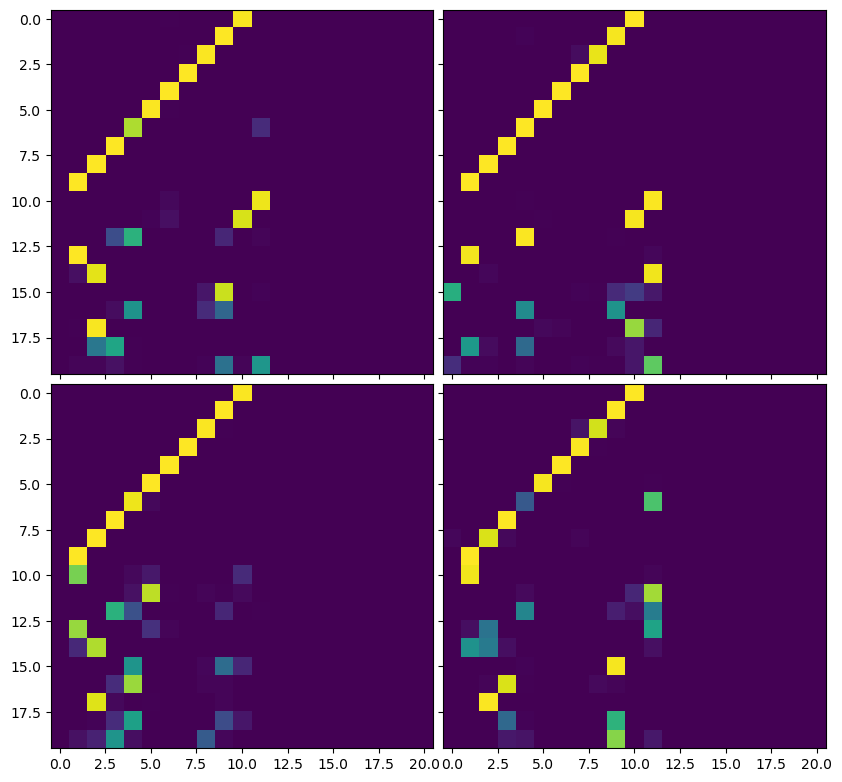

In [3]:
# 可视化注意力
fig = plt.figure(figsize=(10.0, 10.0))
images = (
    model.decoder.decoder_blocks[0]
    .cross_attention.attention_weights[0, ...]
    .detach()
    .numpy()
)
grid = ImageGrid(
    fig,
    111,  # 类似于 subplot(111)
    nrows_ncols=(2, 2),  # 创建2x2的坐标轴网格
    axes_pad=0.1,  # 坐标轴之间的间距（以英寸为单位）
)
for ax, im in zip(grid, images):
    # 遍历网格返回Axes。
    ax.imshow(im)

In [3]:
# 测试模型
class Translator(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer

    @staticmethod
    def str_to_tokens(s):
        return [ord(z) - 97 + 3 for z in s]

    @staticmethod
    def tokens_to_str(tokens):
        return "".join([chr(x + 94) for x in tokens])

    def __call__(self, sentence, max_length=None, pad=False):
        x = torch.tensor(self.str_to_tokens(sentence))
        x = torch.cat(
            [torch.tensor([SOS_IDX]), x, torch.tensor([EOS_IDX])]
        ).unsqueeze(0)

        encoder_output, mask = self.transformer.encode(x)  # (B, S, E)

        if not max_length:
            max_length = x.size(1)

        outputs = (
            torch.ones((x.size()[0], max_length)).type_as(x).long() * SOS_IDX
        )

        for step in range(1, max_length):
            y = outputs[:, :step]
            probs = self.transformer.decode(y, encoder_output)
            output = torch.argmax(probs, dim=-1)
            print(f"Knowing {y} we output {output[:, -1]}")
            if output[:, -1].detach().numpy() in (EOS_IDX, SOS_IDX):
                break
            outputs[:, step] = output[:, -1]

        return self.tokens_to_str(outputs[0])

translator = Translator(model)

NameError: name 'nn' is not defined

In [1]:
# 注意，模型不支持小写字母意外的内容，包括大写字母，空格等
sentence = "helloworld"
out = translator(sentence)
print(out)

# 创建一个子图对象
fig, ax = plt.subplots(1, 1, figsize=(10.0, 10.0))
# 设置y轴刻度
ax.set_yticks(range(len(out)))
# 设置x轴刻度
ax.set_xticks(range(len(sentence)))

# 将x轴标签位置设置在顶部
ax.xaxis.set_label_position("top")

# 设置x轴刻度标签
ax.set_xticklabels(iter(sentence))
# 设置y轴刻度标签
ax.set_yticklabels([f"step {i}" for i in range(len(out))])
# 显示图像
ax.imshow(images)

NameError: name 'translator' is not defined